# Latest

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# Download MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Filter classes 1 and 7
classes_17 = [1, 7]

train_mask = torch.tensor([label in classes_17 for label in train_dataset.targets])
test_mask = torch.tensor([label in classes_17 for label in test_dataset.targets])

X_train_binary, y_train_binary = train_dataset.data[train_mask], train_dataset.targets[train_mask]
X_test_binary, y_test_binary = test_dataset.data[test_mask], test_dataset.targets[test_mask]


In [23]:
# Subsample and relabel
X_train_binary = X_train_binary[(y_train_binary == 1) | (y_train_binary == 7)]
y_train_binary = torch.where(y_train_binary == 1, torch.tensor(0), torch.tensor(1))

X_test_binary = X_test_binary[(y_test_binary == 1) | (y_test_binary == 7)]
y_test_binary = torch.where(y_test_binary == 1, torch.tensor(0), torch.tensor(1))

# Flatten images
X_train_flat = X_train_binary.view(X_train_binary.shape[0], -1).float() / 255.0
X_test_flat = X_test_binary.view(X_test_binary.shape[0], -1).float() / 255.0


In [24]:
def craft_random_lflip(train_set, ratio):
    # Implement the function to flip labels for a ratio% of samples
    num_poisons = int(len(train_set) * ratio)
    indices = np.random.choice(len(train_set), num_poisons, replace=False)
    train_set_poisoned = train_set.clone()  # Make a copy to avoid modifying the original
    train_set_poisoned[indices] = 1 - train_set_poisoned[indices]
    return train_set_poisoned

In [25]:
# Train victim learner (logistic regression)
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

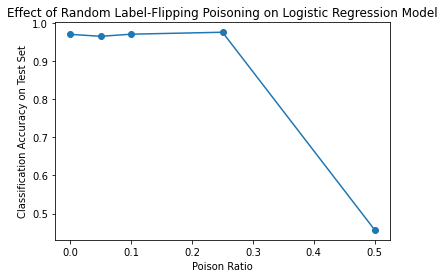

In [26]:
import matplotlib.pyplot as plt

# Experiment and Plot
ratios = [0, 0.05, 0.1, 0.25, 0.5]
accuracies = []

for ratio in ratios:
    # Craft poisoned training set
    poisoned_train_set_y = craft_random_lflip(y_train_binary, ratio)

    # Train logistic regression model
    input_size = X_train_flat.shape[1]
    model = LogisticRegressionModel(input_size)

    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train_flat)
        loss = criterion(outputs, poisoned_train_set_y.float().view(-1, 1))
        loss.backward()

        optimizer.step()


    # Evaluate on clean test set
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_flat)
        predictions = (outputs >= 0.5).float()
        accuracy = torch.sum(predictions == y_test_binary.view(-1, 1)).item() / len(y_test_binary)
        accuracies.append(accuracy)

# Plot the results
plt.plot(ratios, accuracies, marker='o')
plt.xlabel('Poison Ratio')
plt.ylabel('Classification Accuracy on Test Set')
plt.title('Effect of Random Label-Flipping Poisoning on Logistic Regression Model')
plt.show()

In [27]:
accuracies


[0.9699491447064262,
 0.9648636153490523,
 0.9704114655570967,
 0.9754969949144706,
 0.4572353213129912]

# Problem 2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Step 1: Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Hyperparameters
batch_size = 128
learning_rate = 0.01
num_epochs = 100

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
from tqdm import tqdm
# Step 2: Train ResNet18 model
def train_resnet18(train_loader, val_loader, num_epochs=10):
    resnet18 = models.resnet18(pretrained=False)
    resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)  # Change the output size for CIFAR-10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)


    for epoch in tqdm(range(num_epochs)):
        resnet18.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        resnet18.eval()
        with torch.no_grad():
            val_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = resnet18(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {100 * correct / total}%")

    return resnet18

In [4]:
# Train the ResNet18 model
trained_resnet18 = train_resnet18(train_loader, test_loader)

 10%|████████▎                                                                          | 1/10 [00:34<05:09, 34.42s/it]

Epoch 1/10, Validation Accuracy: 55.89%


 20%|████████████████▌                                                                  | 2/10 [01:05<04:18, 32.27s/it]

Epoch 2/10, Validation Accuracy: 62.94%


 30%|████████████████████████▉                                                          | 3/10 [01:37<03:46, 32.30s/it]

Epoch 3/10, Validation Accuracy: 64.86%


 40%|█████████████████████████████████▏                                                 | 4/10 [02:08<03:11, 31.96s/it]

Epoch 4/10, Validation Accuracy: 67.95%


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:41<02:41, 32.20s/it]

Epoch 5/10, Validation Accuracy: 67.46%


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:12<02:07, 31.82s/it]

Epoch 6/10, Validation Accuracy: 68.89%


 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:43<01:34, 31.56s/it]

Epoch 7/10, Validation Accuracy: 69.23%


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:15<01:03, 31.69s/it]

Epoch 8/10, Validation Accuracy: 68.74%


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:47<00:31, 31.79s/it]

Epoch 9/10, Validation Accuracy: 69.95%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:18<00:00, 31.87s/it]

Epoch 10/10, Validation Accuracy: 70.7%


In [13]:
torch.save(trained_resnet18.state_dict(), 'resnet18_cifar10_p.pth')

In [14]:
trained_resnet18 = models.resnet18(pretrained=False)
trained_resnet18.fc = nn.Linear(trained_resnet18.fc.in_features, 10)
trained_resnet18.to(device)

# Load the saved model state dictionary
trained_resnet18.load_state_dict(torch.load('resnet18_cifar10_p.pth'))

<All keys matched successfully>

In [15]:
feature_extract = nn.Sequential(*list(trained_resnet18.children())[:-1])
feature_extract.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [16]:
classes = test_dataset.classes
deer_class = classes.index('deer')
cat_class = classes.index('cat')

# List comprehension to get indices of images with a specific class
def get_indices(dataset, class_idx, num_samples):
    return [i for i, (_, label) in enumerate(dataset) if label == class_idx][:num_samples]

# Select 5 deer images and 100 cat images
deer_indices = get_indices(test_dataset, deer_class, 5)
print("deer indices:", deer_indices)

cat_indices = get_indices(test_dataset, cat_class, 100)
print("cat indices:", cat_indices)


deer indices: [22, 26, 32, 36, 40]
cat indices: [0, 8, 46, 53, 61, 63, 68, 77, 78, 91, 103, 106, 115, 121, 127, 143, 176, 184, 187, 205, 224, 245, 251, 256, 271, 273, 277, 279, 294, 302, 320, 323, 332, 336, 356, 367, 397, 399, 412, 418, 426, 432, 434, 438, 453, 456, 464, 467, 470, 515, 558, 565, 573, 586, 597, 599, 607, 608, 637, 641, 646, 650, 664, 669, 671, 673, 676, 688, 690, 695, 715, 716, 727, 739, 760, 786, 790, 792, 811, 819, 825, 829, 831, 845, 862, 863, 866, 870, 874, 878, 882, 896, 898, 911, 916, 932, 945, 948, 950, 957]


In [17]:
LR=0.01
beta=0.25
max_iter=1000
K=[1, 5, 10, 25, 50, 100]
number_epochs=10
learningRate=0.1
BS=128

In [18]:
modified_cifar10_dataset = [(x, y) for x,y in (test_dataset)]## to take 100 base samples for cat and 5 target samples for the deer class
finetunetrainset=[(x, y) for x,y in (train_dataset)]

In [19]:
dict = {}

for taridx in deer_indices:    
    #print(f"sample from deer class with index: {taridx}")
    dict[f'Deer_{taridx}'] = {'K': [], 'attack': []}
    for k in K:# list of number of required poisoned samples
        #renewing the dataset
        #print("\nk:",k)
        dict[f'Deer_{taridx}']['K'].append(k)
        train_cifar10_dataset = finetunetrainset.copy()
        print("\nbefore trainset length",len(train_cifar10_dataset))
        model_finetune = models.resnet18(pretrained=False)
        model_finetune.fc = nn.Linear(model_finetune.fc.in_features, 10)
        model_finetune.to(device)

        model_finetune.load_state_dict(torch.load('resnet18_cifar10_p.pth'))#loading the pretrained weight.

        print("\n---------generating poisoned samples--------\n")
        for baseidx in tqdm(cat_indices[:k]):##datacreation part
            baseinput,target = modified_cifar10_dataset[baseidx]
            temp = baseinput.clone()
            baseinput = baseinput.requires_grad_()
            Tfeature=feature_extract(modified_cifar10_dataset[taridx][0].view(-1,3,32,32).to(device)).detach()
            for iter in (range(max_iter)):
                Bfeature=feature_extract(baseinput.view(-1,3,32,32).to(device))
                loss = torch.norm(Bfeature-Tfeature,p=2)
                gradient = torch.autograd.grad(loss, baseinput)
                baseinput = baseinput-LR*gradient[0] #forward process
                baseinput = (baseinput + LR*beta*temp)/(1+LR*beta)
            train_cifar10_dataset.append((baseinput.detach(),target))

        print("\nafter trainset length",len(train_cifar10_dataset))
        finetune_loader = DataLoader(train_cifar10_dataset, batch_size=BS, shuffle=True, num_workers=4)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_finetune.parameters(), lr=0.01, weight_decay=0)

        ##freezing the other layers
        for name, param in model_finetune.named_parameters():
            if "fc" in name:  # Assuming the fully connected layer is named "fc"
                param.requires_grad = True
            else:
                param.requires_grad = False

        #finetuning loop
        print("\n--------finetuning--------\n")
        for epoch in range(number_epochs):
            model_finetune.train()
            running_loss = 0.0
            for inputs, labels in tqdm(finetune_loader):
                inputs, labels = inputs.cuda(), labels.to(device) # Move data to GPU
                optimizer.zero_grad()
                outputs = model_finetune(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            #print(f'Epoch {epoch + 1}/{number_epochs}, Loss: {running_loss / len(finetune_loader)}')

        ##testing loop
        print("--------testing--------")
        model_finetune.eval()
        pred = model_finetune(modified_cifar10_dataset[taridx][0].view(-1,3,32,32).to(device))
        _,pred=torch.max(pred, 1)
        print("prediction:",pred)
        if pred==3:## class of cats!
            dict[f'Deer_{taridx}']['attack'].append("success")
            print("success!!")
        else:
            dict[f'Deer_{taridx}']['attack'].append("not success")
            print("not success :/")





before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.79s/it]



after trainset length 50001

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.65it/s]


--------testing--------
prediction: tensor([0], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.07s/it]



after trainset length 50005

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.74it/s]


--------testing--------
prediction: tensor([0], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:47<00:00, 10.73s/it]



after trainset length 50010

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.84it/s]


--------testing--------
prediction: tensor([0], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:29<00:00, 10.78s/it]



after trainset length 50025

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.73it/s]


--------testing--------
prediction: tensor([0], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:18<00:00, 11.16s/it]



after trainset length 50050

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 392/392 [00:28<00:00, 13.60it/s]


--------testing--------
prediction: tensor([3], device='cuda:0')
success!!

before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [18:04<00:00, 10.85s/it]



after trainset length 50100

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 392/392 [00:28<00:00, 13.87it/s]


--------testing--------
prediction: tensor([3], device='cuda:0')
success!!

before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.76s/it]



after trainset length 50001

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.74it/s]


--------testing--------
prediction: tensor([4], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.74s/it]



after trainset length 50005

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.75it/s]


--------testing--------
prediction: tensor([4], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:48<00:00, 10.89s/it]



after trainset length 50010

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.76it/s]


--------testing--------
prediction: tensor([4], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:29<00:00, 10.80s/it]



after trainset length 50025

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.65it/s]


--------testing--------
prediction: tensor([3], device='cuda:0')
success!!

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [08:59<00:00, 10.79s/it]



after trainset length 50050

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 392/392 [00:28<00:00, 13.67it/s]


--------testing--------
prediction: tensor([3], device='cuda:0')
success!!

before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [18:00<00:00, 10.80s/it]



after trainset length 50100

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 392/392 [00:28<00:00, 13.61it/s]


--------testing--------
prediction: tensor([3], device='cuda:0')
success!!

before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.66s/it]



after trainset length 50001

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.74it/s]


--------testing--------
prediction: tensor([4], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.91s/it]



after trainset length 50005

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.55it/s]


--------testing--------
prediction: tensor([4], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:53<00:00, 11.35s/it]



after trainset length 50010

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.83it/s]


--------testing--------
prediction: tensor([4], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:37<00:00, 11.10s/it]



after trainset length 50025

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.65it/s]


--------testing--------
prediction: tensor([3], device='cuda:0')
success!!

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:00<00:00, 10.80s/it]



after trainset length 50050

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 392/392 [00:28<00:00, 13.58it/s]


--------testing--------
prediction: tensor([3], device='cuda:0')
success!!

before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [18:02<00:00, 10.82s/it]



after trainset length 50100

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 392/392 [00:28<00:00, 13.81it/s]


--------testing--------
prediction: tensor([3], device='cuda:0')
success!!

before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.76s/it]



after trainset length 50001

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.66it/s]


--------testing--------
prediction: tensor([5], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.87s/it]



after trainset length 50005

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.73it/s]


--------testing--------
prediction: tensor([4], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:47<00:00, 10.75s/it]



after trainset length 50010

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.56it/s]


--------testing--------
prediction: tensor([5], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:29<00:00, 10.78s/it]



after trainset length 50025

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.94it/s]


--------testing--------
prediction: tensor([3], device='cuda:0')
success!!

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:00<00:00, 10.80s/it]



after trainset length 50050

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 392/392 [00:28<00:00, 13.71it/s]


--------testing--------
prediction: tensor([3], device='cuda:0')
success!!

before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [18:01<00:00, 10.81s/it]



after trainset length 50100

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 392/392 [00:28<00:00, 13.78it/s]


--------testing--------
prediction: tensor([3], device='cuda:0')
success!!

before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.82s/it]



after trainset length 50001

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.84it/s]


--------testing--------
prediction: tensor([4], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.73s/it]



after trainset length 50005

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.74it/s]


--------testing--------
prediction: tensor([4], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:49<00:00, 10.95s/it]



after trainset length 50010

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.73it/s]


--------testing--------
prediction: tensor([4], device='cuda:0')
not success :/

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [04:31<00:00, 10.85s/it]



after trainset length 50025

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 391/391 [00:28<00:00, 13.63it/s]


--------testing--------
prediction: tensor([3], device='cuda:0')
success!!

before trainset length 50000

---------generating poisoned samples--------



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:01<00:00, 10.82s/it]



after trainset length 50050

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 392/392 [00:28<00:00, 13.68it/s]


--------testing--------
prediction: tensor([3], device='cuda:0')
success!!

before trainset length 50000

---------generating poisoned samples--------



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [18:02<00:00, 10.82s/it]



after trainset length 50100

--------finetuning--------



100%|████████████████████████████████████████████████████████████████████████████████| 392/392 [00:28<00:00, 13.77it/s]

--------testing--------
prediction: tensor([3], device='cuda:0')
success!!


In [20]:
dict

{'Deer_22': {'K': [1, 5, 10, 25, 50, 100],
  'attack': ['not success',
   'not success',
   'not success',
   'not success',
   'success',
   'success']},
 'Deer_26': {'K': [1, 5, 10, 25, 50, 100],
  'attack': ['not success',
   'not success',
   'not success',
   'success',
   'success',
   'success']},
 'Deer_32': {'K': [1, 5, 10, 25, 50, 100],
  'attack': ['not success',
   'not success',
   'not success',
   'success',
   'success',
   'success']},
 'Deer_36': {'K': [1, 5, 10, 25, 50, 100],
  'attack': ['not success',
   'not success',
   'not success',
   'success',
   'success',
   'success']},
 'Deer_40': {'K': [1, 5, 10, 25, 50, 100],
  'attack': ['not success',
   'not success',
   'not success',
   'success',
   'success',
   'success']}}